In [8]:
import h5py
import numpy as np

path = "../Data/simulation_data.h5"

def load_groups_with_pressure_proxy(path):
    records = []
    with h5py.File(path, "r") as f:
        groups = sorted(list(f.keys()))
        for gname in groups:
            g = f[gname]
            X = np.asarray(g["mesh_pos"][:], dtype=np.float32)          # (N,3)
            d = np.asarray(g["deformation"][:], dtype=np.float32)       # (N,)  (|u_y| or u_y>=0)
            vm = np.asarray(g["eq_stress"][:], dtype=np.float32)        # (N,)
            cells = np.asarray(g["cells"][:], dtype=np.int64)           # (M,8)

            # load/pressure proxy for this simulation case
            p_proxy = float(d.max())  # scalar per group

            records.append({
                "group": gname,
                "X": X,
                "d": d,
                "vm": vm,
                "cells": cells,
                "p_proxy": p_proxy,
            })
    return records

data = load_groups_with_pressure_proxy(path)

print("Loaded groups:", len(data))
print("Example group:", data[0]["group"])
print("Shapes: X", data[0]["X"].shape, "| d", data[0]["d"].shape, "| vm", data[0]["vm"].shape, "| cells", data[0]["cells"].shape)
print("p_proxy example:", data[0]["p_proxy"])


Loaded groups: 20
Example group: group_01
Shapes: X (3872, 3) | d (3872,) | vm (3872,) | cells (1845, 8)
p_proxy example: 1.0359000270909746e-06


In [9]:
#if proxy makes sense (does it vary across groups?)

pvals = np.array([r["p_proxy"] for r in data], dtype=np.float64)
print("p_proxy min/max:", pvals.min(), pvals.max())
print("p_proxy values (sorted):")
print(np.sort(pvals))


p_proxy min/max: 1.0359000270909746e-06 2.1558998923865147e-06
p_proxy values (sorted):
[1.03590003e-06 1.06640005e-06 1.09650000e-06 1.12789996e-06
 1.16110004e-06 1.19890001e-06 1.22819995e-06 1.27600003e-06
 1.32219998e-06 1.36230005e-06 1.41359999e-06 1.47250000e-06
 1.53780002e-06 1.60130003e-06 1.66710004e-06 1.76339995e-06
 1.84650003e-06 1.94850008e-06 2.05419997e-06 2.15589989e-06]


corr(p_proxy, max_vm) = 0.9789999593863326


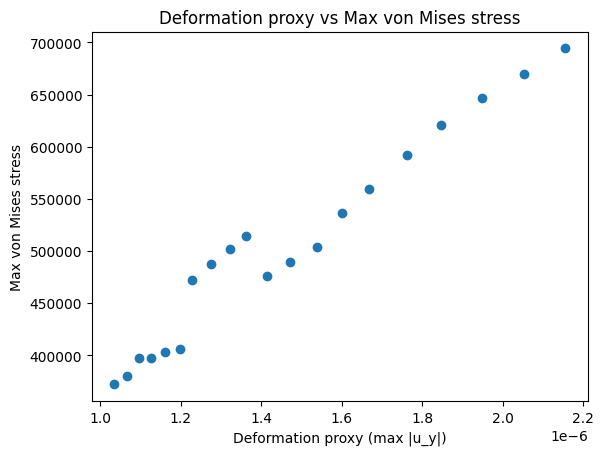

In [18]:
# quick check if higher proxy means higher stress values
import matplotlib.pyplot as plt

pairs = []
for r in data:
    pairs.append((r["p_proxy"], float(r["vm"].max())))
pairs = np.array(pairs)

# Sort by deformation proxy
pairs = pairs[np.argsort(pairs[:,0])]

# Correlation (should be strongly positive)
corr = np.corrcoef(pairs[:,0], pairs[:,1])[0,1]
print("corr(p_proxy, max_vm) =", corr)

# Scatter plot
plt.scatter(pairs[:,0], pairs[:,1]) 
plt.xlabel("Deformation proxy (max |u_y|)")
plt.ylabel("Max von Mises stress")
plt.title("Deformation proxy vs Max von Mises stress")
plt.show()



In [20]:
import numpy as np

# Stack everything to compute global scales
X_all = np.vstack([r["X"] for r in data])             # (sum N, 3)
vm_all = np.hstack([r["vm"] for r in data])           # (sum N,)
p_all = np.array([r["p_proxy"] for r in data])        # (num_groups,)

# Coordinate normalization to [-1,1]
x_min = X_all.min(axis=0)
x_max = X_all.max(axis=0)
x_scale = x_max - x_min
x_scale[x_scale == 0] = 1.0

def normalize_X(X):
    return 2.0 * (X - x_min) / x_scale - 1.0

# Pressure proxy normalization to [0,1]
p_min, p_max = p_all.min(), p_all.max()
p_scale = p_max - p_min

def normalize_p(p):
    return (p - p_min) / p_scale

# Stress normalization (scale only, keep sign)
vm_scale = np.max(vm_all)

def normalize_vm(vm):
    return vm / vm_scale

def denormalize_vm(vm_n):
    return vm_n * vm_scale

print("Scales:")
print("x range:", x_min, x_max)
print("p range:", p_min, p_max)
print("vm scale:", vm_scale)


Scales:
x range: [ 0.        0.       -1.163182] [0.1461 0.2514 0.    ]
p range: 1.0359000270909746e-06 2.1558998923865147e-06
vm scale: 694210.0


In [22]:
X_list = []
Y_list = []

for r in data:
    Xn = normalize_X(r["X"])                           # (N,3)
    p_n = normalize_p(r["p_proxy"])                    # scalar
    p_col = np.full((Xn.shape[0], 1), p_n, dtype=np.float32)

    inp = np.hstack([Xn, p_col])                       # (N,4)
    out = normalize_vm(r["vm"]).reshape(-1, 1)         # (N,1)

    X_list.append(inp)
    Y_list.append(out)

X_train = np.vstack(X_list).astype(np.float32)
Y_train = np.vstack(Y_list).astype(np.float32)

print("Final dataset shapes:")
print("X_train:", X_train.shape)   # (total_nodes, 4)
print("Y_train:", Y_train.shape)   # (total_nodes, 1)


Final dataset shapes:
X_train: (76590, 4)
Y_train: (76590, 1)


In [24]:
print("Input ranges:")
print("x,y,z min:", X_train[:,:3].min(axis=0))
print("x,y,z max:", X_train[:,:3].max(axis=0))
print("p min/max:", X_train[:,3].min(), X_train[:,3].max())

print("Target range (normalized vm):", Y_train.min(), Y_train.max())


Input ranges:
x,y,z min: [-1. -1. -1.]
x,y,z max: [1. 1. 1.]
p min/max: 0.0 1.0
Target range (normalized vm): 0.00068905664 1.0


In [26]:
#defining the baseline network
import torch
import torch.nn as nn

class BaselineMLP(nn.Module):
    def __init__(self, in_dim=4, width=128, depth=4):
        super().__init__()
        layers = [nn.Linear(in_dim, width), nn.ReLU()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), nn.ReLU()]
        layers += [nn.Linear(width, 1)]
        self.net = nn.Sequential(*layers)

        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)


In [ ]:
device = "cpu"

X_t = torch.tensor(X_train, dtype=torch.float32, device=device)
Y_t = torch.tensor(Y_train, dtype=torch.float32, device=device)

model = BaselineMLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

print("Training on:", device)


Training on: cpu


In [ ]:
#taining the baseline model

batch_size = 4096
epochs = 2000
N = X_t.shape[0]

for ep in range(1, epochs + 1):
    idx = torch.randint(0, N, (batch_size,), device=device)
    xb = X_t[idx]
    yb = Y_t[idx]

    pred = model(xb)
    loss = loss_fn(pred, yb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 200 == 0 or ep == 1:
        print(f"ep {ep:4d} | mse {loss.item():.4e}")



ep    1 | mse 1.9940e+00
ep  200 | mse 5.4020e-03
ep  400 | mse 4.4268e-03
ep  600 | mse 3.9246e-03
ep  800 | mse 3.7385e-03
ep 1000 | mse 2.9977e-03
ep 1200 | mse 3.1800e-03
ep 1400 | mse 3.1388e-03
ep 1600 | mse 2.7358e-03
ep 1800 | mse 2.8230e-03
ep 2000 | mse 2.3913e-03


In [ ]:
#evaluating on training data

with torch.no_grad():
    pred_all = model(X_t).cpu().numpy().ravel()

true_all = Y_train.ravel()

mse = np.mean((pred_all - true_all) ** 2)
print("Final training MSE (normalized vm):", mse)
